In [4]:
import pandas as pd

# Read and prepare ts1
ts1 = pd.read_csv("final_timeseries_1.csv", parse_dates=["date"])
ts1 = ts1.set_index("date").sort_index()

# Read and prepare ts2
ts2 = pd.read_csv("final_timeseries_2.csv", parse_dates=["date"])
ts2 = ts2.set_index("date").sort_index()

# Build full date range
min_date = ts1.index.min()
max_date = ts1.index.max()
full_range = pd.date_range(start=min_date, end=max_date, freq="D")

# Reindex to full range
ts1_full = ts1.reindex(full_range)
ts2_full = ts2.reindex(full_range)

# name the index 'date' so we can reset it later
ts1_full.index.name = "date"
ts2_full.index.name = "date"

ts1_full.head(), ts2_full.head()


(            demand
 date              
 2022-01-01     NaN
 2022-01-02   102.0
 2022-01-03   113.0
 2022-01-04   125.0
 2022-01-05   111.0,
             demand
 date              
 2022-01-01   104.0
 2022-01-02   145.0
 2022-01-03   138.0
 2022-01-04   105.0
 2022-01-05   109.0)

In [8]:
# Create copies of ts1_full and ts2_full for cleaning
ts1_clean = ts1_full.copy()
ts2_clean = ts2_full.copy()


In [9]:
# Check missing values in both cleaned series
ts1_clean.isna().sum(), ts2_clean.isna().sum()


(demand    70
 dtype: int64,
 demand    70
 dtype: int64)

In [10]:
# Interpolate internal gaps using the time index
ts1_clean["demand"] = ts1_clean["demand"].interpolate(method="time")
ts2_clean["demand"] = ts2_clean["demand"].interpolate(method="time")

# If there are NaNs at the very start or end, fill them from neighbors
ts1_clean["demand"] = ts1_clean["demand"].bfill().ffill()
ts2_clean["demand"] = ts2_clean["demand"].bfill().ffill()

# Check that we no longer have missing values
ts1_clean.isna().sum(), ts2_clean.isna().sum()


(demand    0
 dtype: int64,
 demand    0
 dtype: int64)

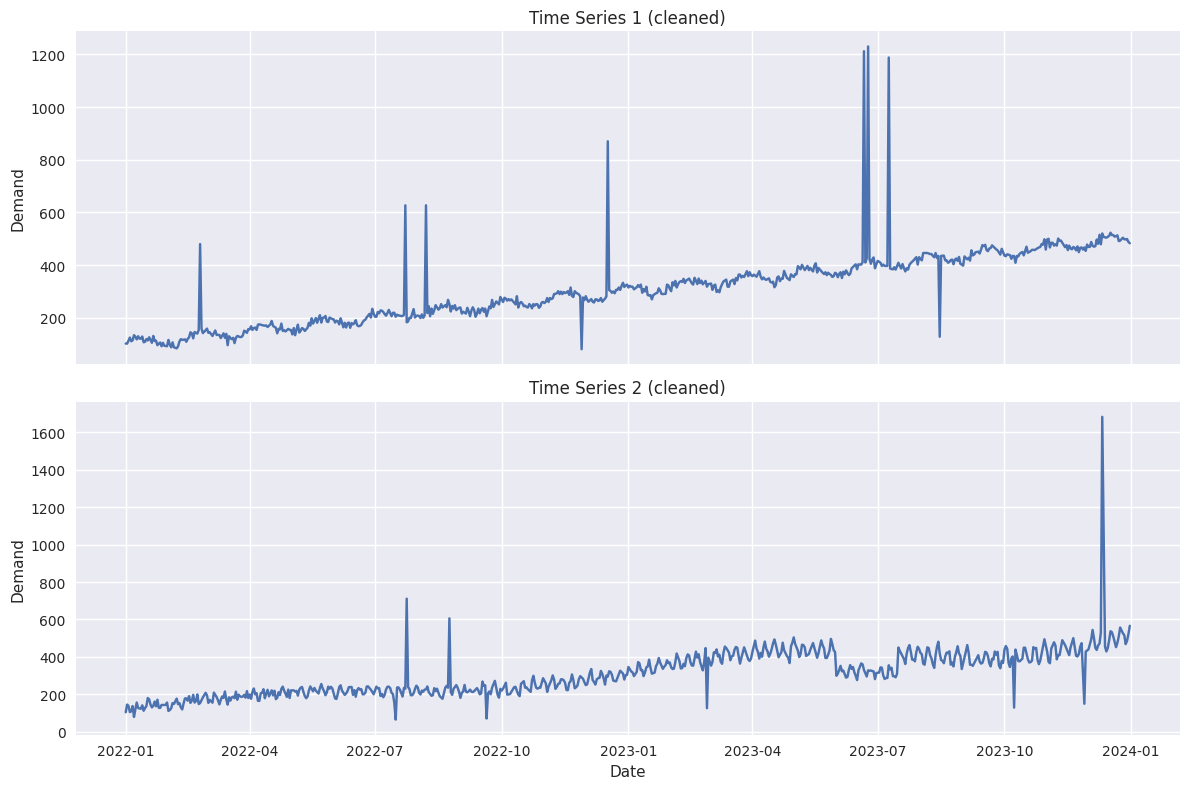

In [11]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# ts1 cleaned
axes[0].plot(ts1_clean.index, ts1_clean["demand"])
axes[0].set_title("Time Series 1 (cleaned)")
axes[0].set_ylabel("Demand")
axes[0].grid(True)

# ts2 cleaned
axes[1].plot(ts2_clean.index, ts2_clean["demand"])
axes[1].set_title("Time Series 2 (cleaned)")
axes[1].set_ylabel("Demand")
axes[1].set_xlabel("Date")
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [12]:
# reset index so 'date' becomes a column again
ts1_clean_out = ts1_clean.reset_index()
ts2_clean_out = ts2_clean.reset_index()

# save to CSV
ts1_clean_out.to_csv("final_timeseries_1_cleaned.csv", index=False)
ts2_clean_out.to_csv("final_timeseries_2_cleaned.csv", index=False)


In [13]:
print("ts1_clean rows:", len(ts1_clean))
print("ts2_clean rows:", len(ts2_clean))

print("ts1_clean missing:", ts1_clean.isna().sum())
print("ts2_clean missing:", ts2_clean.isna().sum())


ts1_clean rows: 730
ts2_clean rows: 730
ts1_clean missing: demand    0
dtype: int64
ts2_clean missing: demand    0
dtype: int64
